In [1]:
%%capture
!pip install "cvxpy[OSQP]"

In [1]:
!git clone https://github.com/shaoanlu/pyNMPC.git
%cd pyNMPC

fatal: destination path 'pyNMPC' already exists and is not an empty directory.
/content/pyNMPC


In [2]:
from pyNMPC.nmpc import NMPC, MPCParams, MPCResult

In [3]:
import jax.numpy as jnp

# Quadrotor parameters
m_q = 1.0 # kg
m_p = 0.2 # kg
I_xx = 0.1 # kg.m^2
l_q = 0.3 # m, length of the quadrotor
l_p = 1.3 # m, length of the pendulum
g = 9.81

def dynamics(x, u, dt, m_q=m_q, m_p=m_p, g=g, I_xx=I_xx, l_p=l_p):
    # model adopted from
    # https://github.com/shaoanlu/mppi_cbf/blob/main/planar_quadrotor_pendulum_mppi_cbf.ipynb
    y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot = x
    u1, u2 = u
    total_mass = (m_q + m_p)

    # Quadrotor dynamics
    y_ddot = (m_q + m_p*jnp.cos(theta)**2) / (m_q*total_mass) * u1 * jnp.sin(phi) + \
     (m_p*jnp.cos(theta)*jnp.sin(theta)) / (m_q*total_mass) * u1 * jnp.cos(phi) + \
      (m_p*l_p*(theta_dot**2)*jnp.sin(theta)) / total_mass
    z_ddot = -g + (m_q + m_p*jnp.sin(theta)**2) / (m_q*total_mass) * u1 * jnp.cos(phi) + \
     (m_p*jnp.cos(theta)*jnp.sin(theta)) / (m_q*total_mass) * u1 * jnp.sin(phi) + \
      (m_p*l_p*(theta_dot**2)*jnp.cos(theta)) / total_mass
    phi_ddot = u2 / I_xx
    theta_ddot = -jnp.cos(theta) / (m_q*l_p) * u1 * jnp.sin(phi) - jnp.sin(theta) / (m_q*l_p) * u1 * jnp.cos(phi)

    next_state = x + jnp.array([y_dot, y_ddot, z_dot, z_ddot, phi_dot, phi_ddot, theta_dot, theta_ddot]) * dt
    return next_state

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import time
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict, Any
from IPython.display import HTML


class SimulationResults:
    """Container for closed-loop simulation results."""
    def __init__(self):
        self.states = []       # List of states [x, y, theta]
        self.controls = []     # List of controls [v, omega]
        self.mpc_results = []  # List of MPC results at each timestep
        self.references = []   # List of reference states
        self.timestamps = []   # List of timesteps
        self.computation_times = []  # List of MPC computation times

    def add_step(self, state: np.ndarray, control: np.ndarray, mpc_result: MPCResult,
                 reference: np.ndarray, timestamp: float, computation_time: float):
        """Add a simulation step to the results."""
        self.states.append(state.copy())
        self.controls.append(control.copy())
        self.mpc_results.append(mpc_result)
        self.references.append(reference.copy())
        self.timestamps.append(timestamp)
        self.computation_times.append(computation_time)

    def get_arrays(self):
        """Convert lists to numpy arrays for easier plotting."""
        return {
            'states': np.array(self.states),
            'controls': np.array(self.controls),
            'references': np.array(self.references),
            'timestamps': np.array(self.timestamps),
            'computation_times': np.array(self.computation_times)
        }


def run_closed_loop_simulation(
    x0: jnp.ndarray,
    reference_trajectory: List[jnp.ndarray],
    params: MPCParams,
    sim_time: float = 10.0,
    controller_dt: float = 0.1,
    sim_dt: Optional[float] = None
) -> SimulationResults:
    """
    Run a closed-loop simulation of the unicycle model with MPC control.

    Args:
        x0: Initial state [x, y, theta]
        reference_trajectory: List of reference states for each timestep
        params: MPC parameters
        sim_time: Total simulation time
        controller_dt: Control update interval
        sim_dt: Simulation timestep (defaults to controller_dt if None)

    Returns:
        SimulationResults object with simulation data
    """
    # Use controller_dt for simulation if sim_dt is not specified
    sim_dt = sim_dt or controller_dt

    # Initialize simulation variables
    current_state = x0.copy()
    current_time = 0.0
    results = SimulationResults()

    # Store the initial state
    # Initial control is [0, 0] and initial MPC result is None
    results.add_step(
        current_state,
        jnp.zeros(2),
        None,
        reference_trajectory[0],
        current_time,
        0.0
    )

    # Control update counter and timing
    control_update_time = 0.0
    current_control = jnp.zeros(2)
    mpc_result = None
    latest_mpc_result = None

    # Create cvxpy problem
    mpc = NMPC(dynamics_fn=dynamics, params=params)

    # Main simulation loop with tqdm
    pbar = tqdm(total=int(sim_time / sim_dt), desc="Simulation Progress", ncols=100)

    # Main simulation loop
    while current_time < sim_time:
        # Update control if it's time (control updates happen at intervals of controller_dt)
        if abs(current_time - control_update_time) < 1e-6 or current_time > control_update_time:
            # Run MPC
            start_time = time.time()
            mpc_result = mpc.solve(x0=current_state, mpc_result=mpc_result)
            computation_time = time.time() - start_time

            # Extract the first control action
            current_control = mpc_result.u_traj[0]
            latest_mpc_result = mpc_result

            # Update next control update time
            control_update_time = current_time + controller_dt

        # Apply control to the system and integrate dynamics
        next_state = dynamics(current_state, current_control, sim_dt)

        # Update simulation time and state
        current_time += sim_dt
        current_state = next_state

        # Store results
        results.add_step(
            current_state,
            current_control,
            latest_mpc_result,
            params.x_ref,
            current_time,
            computation_time if latest_mpc_result else 0.0
        )

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix({
            'Sim Time': f"{current_time:.2f}s",
            'Ctrl Update': f"{control_update_time:.2f}s",
            'MPC Time': f"{computation_time:.3f}s" if latest_mpc_result else 'N/A'
        })

    return results

def plot_simulation_results(results):
  states = results.states
  plt.figure()
  plt.gca().set_aspect('equal', adjustable='box')
  ys = [s[0] for s in states]
  zs = [s[2] for s in states]
  phis = [s[4] for s in states]
  thetas = [s[6] for s in states]

  # Plot the trajectory
  plt.scatter(ys, zs)

  # Plot quadrotor pose
  y_ = [(y-l_q*np.cos(phi), y+l_q*np.cos(phi)) for (y, phi) in zip(ys[::10], phis[::10])]
  z_ = [(z-l_q*np.sin(phi), z+l_q*np.sin(phi)) for (z, phi) in zip(zs[::10], phis[::10])]
  for yy, zz in zip(y_, z_):
    plt.plot(yy, zz, marker="o", color="r", alpha=0.5)

  # Plot payload
  y_ = [(y, y+l_p*np.sin(theta)) for (y, theta) in zip(ys[::10], thetas[::10])]
  z_ = [(z, z-l_p*np.cos(theta)) for (z, theta) in zip(zs[::10], thetas[::10])]
  for yy, zz in zip(y_, z_):
    plt.plot(yy, zz, marker="o", color="k", alpha=0.5)

  # plot start and end point
  plt.scatter(0.0, 0.0, s=200, color="green", alpha=0.75, label="init. position")
  plt.scatter(5.0, 5.0, s=200, color="purple", alpha=0.75, label="target position")

  plt.grid(); plt.show()

def run_demo():
    """Run a demonstration of the unicycle MPC with visualization."""
    # MPC parameters
    params = MPCParams(
        dt=0.03,                                # Time step
        N=30,                                  # Horizon length
        n_states=8,                                  # Horizon length
        n_controls=2,                                  # Horizon length
        Q=jnp.diag(jnp.array([125.0, 10.0, 125.0, 10.0, 10.0, 10.0, 200, 1.0])),  # State weights
        QN=jnp.diag(jnp.array([15.0, 30.0, 15.0, 30.0, 10.0, 10.0, 2.0, 100.0]))*200,  # Terminal state weights
        R=jnp.diag(jnp.array([0.3, 0.1])),         # Control input weights
        x_ref=jnp.array([5.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]),          # Target state
        u_min=jnp.array([-30.0, -10.0]),                  # Linear velocity bounds
        u_max=jnp.array([30.0, 10.0]),             # Angular velocity bounds
        max_sqp_iter=10,                       # Max SQP iterations
        sqp_tol=1e-4,                         # SQP convergence tolerance
        verbose=False                         # Verbosity flag
    )

    # Create a reference trajectory (circle)
    sim_time = 10.0

    # Initial state
    x0 = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # Start at the bottom of the circle

    print("Running closed-loop simulation...")
    results = run_closed_loop_simulation(
        x0=x0,
        reference_trajectory=[x0] * int(sim_time/params.dt),
        params=params,
        sim_time=sim_time,
        controller_dt=params.dt
    )

    print("Simulation complete. Generating visualizations...")

    # Plot results
    plot_simulation_results(results)

    # Create animation
    # ani = create_animation(results, interval=50, show_predictions=True)

    return results

Running Unicycle MPC Demo
Running closed-loop simulation...


Simulation Progress:  17%|▏| 55/333 [00:10<00:59,  4.66it/s, Sim Time=1.65s, Ctrl Update=1.65s, MPC /usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Simulation Progress: 334it [00:42,  7.85it/s, Sim Time=10.02s, Ctrl Update=10.02s, MPC Time=0.031s]


Simulation complete. Generating visualizations...


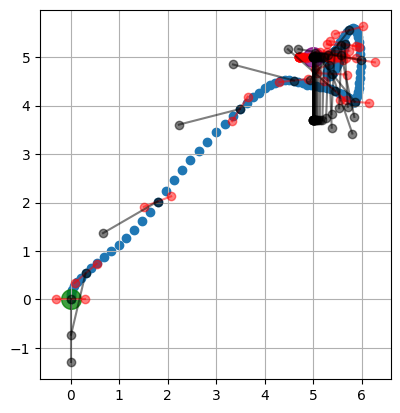

In [5]:
print("Running Unicycle MPC Demo")
results = run_demo()

frame 0/112 completed.
frame 0/112 completed.
frame 10/112 completed.
frame 20/112 completed.
frame 30/112 completed.
frame 40/112 completed.
frame 50/112 completed.
frame 60/112 completed.
frame 70/112 completed.
frame 80/112 completed.
frame 90/112 completed.
frame 100/112 completed.
frame 110/112 completed.


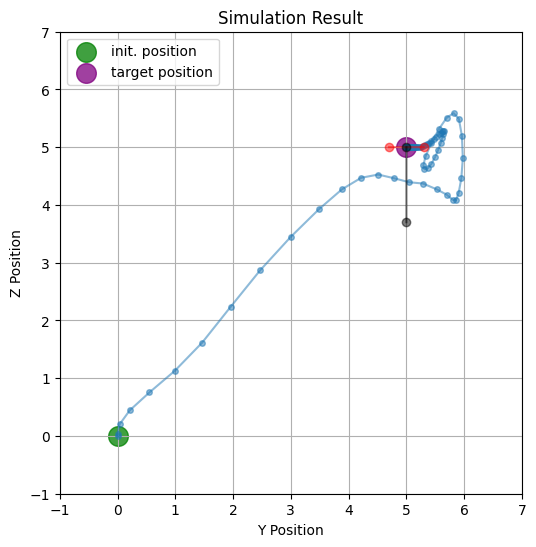

In [6]:
def animate_simulation(results, skip_frames=1):
    states = results.states[::skip_frames]
    total_frames = len(states)
    def update(frame, states):
        plt.gca().cla()  # Clear the current axes

        # Set axis limits
        plt.xlim([-1, 7])
        plt.ylim([-1, 7])

        # Set aspect ratio to be equal, so each cell will be square-shaped
        plt.gca().set_aspect('equal', adjustable='box')

        y, _, z, _, phi, _, theta, _ = states[frame]
        ys = [s[0] for s in states]
        zs = [s[2] for s in states]
        phis = [s[4] for s in states]
        thetas = [s[6] for s in states]

        # Plot the trajectory up to the current frame
        plt.plot([state[0] for state in states[:frame+1]], [state[2] for state in states[:frame+1]], '-o', markersize=4, alpha=0.5)

        # Plot the orientation at the current frame
        plt.plot((y-0.3*np.cos(phi), y+0.3*np.cos(phi)), (z-0.3*np.sin(phi), z+0.3*np.sin(phi)), marker="o", color="r", alpha=0.5)

        # Plot payload at the current frame
        plt.plot((y, y+l_p*np.sin(theta)), (z, z-l_p*np.cos(theta)), marker="o", color="k", alpha=0.5)

        # plot start and end point
        plt.scatter(0.0, 0.0, s=200, color="green", alpha=0.75, label="init. position")
        plt.scatter(5.0, 5.0, s=200, color="purple", alpha=0.75, label="target position")

        plt.title('Simulation Result')
        plt.xlabel('Y Position')
        plt.ylabel('Z Position')
        plt.grid(True)
        plt.legend(loc="upper left")
        if frame % 10 == 0:
          print(f"frame {frame}/{total_frames} completed.")

    fig = plt.figure(figsize=(6, 6))
    anim = animation.FuncAnimation(fig, update, frames=total_frames, fargs=(states,), interval=100, blit=False)

    # Create FFMpegWriter
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    anim.save('simulation.gif', writer=writer)

animate_simulation(results, skip_frames=3)

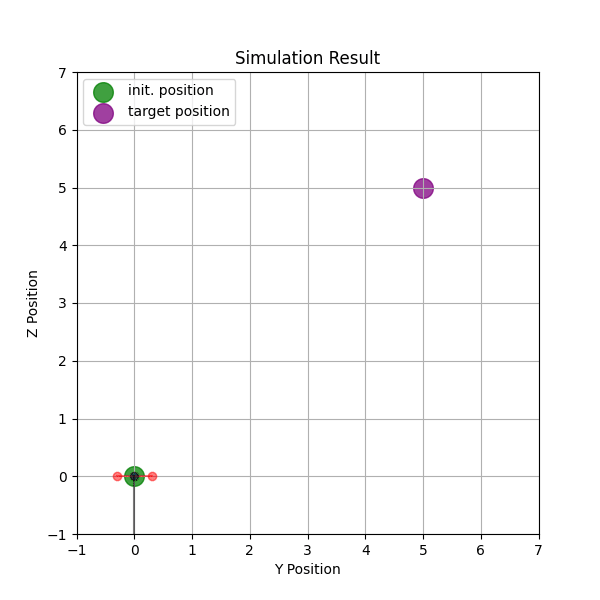

In [7]:
from IPython.display import Image
Image(open('simulation.gif','rb').read())